## DSC 180AB Data Science Capstone
### Replication Project

Team Members:

### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development](#3.-Model-Development)

[4. Model Evaluation](#4.-Model-Evaluation)

[5. Bias Mitigation](#5.-Bias-Mitigation)

[6. Results Summary](#6.-Results-Summary)

[7. Explainability](#7.-Explainability)

[8. Conclusion & Discussion](#8.-Conclusion-&-Discussion)


## This tutorial demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms. It also demonstrates how explanations can be generated for predictions made by models learnt with the toolkit using LIME.

* Classifiers are built using Logistic Regression as well as Random Forests.
* Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.
* Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).
* Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial.


The Medical Expenditure Panel Survey (MEPS) provides nationally representative estimates of health expenditure, utilization, payment sources, health status, and health insurance coverage among the noninstitutionalized U.S. population. These government-produced data sets examine how people use the US healthcare system.

MEPS is administered by the Agency for Healthcare Research and Quality (AHRQ) and is divided into three components: 
* Household
* Insurance/Employer, and 
* Medical Provider. 

These components provide comprehensive national estimates of health care use and payment by individuals, families, and any other demographic group of interest.

### [1.](#Table-of-Contents) Introduction

The [AI Fairness 360 toolkit](https://github.com/Trusted-AI/AIF360) is an extensible open-source library containing techniques developed by the research community to help detect and mitigate bias in machine learning models throughout the AI application lifecycle. AI Fairness 360 documentation is available [here](https://aif360.readthedocs.io/en/stable/).

The AI Fairness 360 package includes: 
- a comprehensive set of metrics for datasets and models to test for biases,
- explanations for these metrics, and
- algorithms to mitigate bias in datasets and models
It is designed to translate algorithmic research from the lab into the actual practice of domains as wide-ranging as finance, human capital management, healthcare, and education

#### 1.1 Use Case

**In order to demonstrate how AIF360 can be used to detect and mitigate bias in classifier models, we adopt the following use case:**

* Data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.
* Developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.
* The app is put into production and starts scoring people and making recommendations. 
* Explanations are generated for each recommendation
* Both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.
* Nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.
* When significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

#### 1.2 Data
Released as an ASCII file (with related SAS, SPSS, and STATA programming statements) and a SAS transport dataset, this public use file provides information collected on a nationally representative sample of the civilian noninstitutionalized population of the United States for calendar year 2015. This file consists of MEPS survey data obtained in Rounds 3, 4, and 5 of Panel 19 and Rounds 1, 2, and 3 of Panel 20 (i.e., the rounds for the MEPS panels covering calendar year 2015) and consolidates all of the final 2015 person-level variables onto one file. This file contains the following variables previously released on HC-174: survey administration, language of interview variable, demographics, parent identifiers, health status, disability days variables, access to care, employment, quality of care, patient satisfaction, health insurance, and use variables. The HC-181 file also includes these variables: income variables and expenditure variables.

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

#### 1.3 Methodology 

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

* Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).
* To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.
* To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

**We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data**
* It is then put into practice and used to score people to identify potential candidates for care management. 
* Initial deployment is simulated to 2015 Panel 20 deployment data. 
* To show change in performance and/or fairness over time, the 2016 Panel 21 deployment data is used. 
* Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data

### 1.4 Insert writeup of overall replication project goals and big picture thinking (2-3 paragraphs).  
* Why do we care about this? 
* What would the benefit of predicting utilization be? 
* What might occur if there are errors?
* Who are the affected parties and stakeholders?
* Other thoughts?

**Write up here:**

This data gives insights into mental and physical health across different ages. Based on the results, people can better target groups based on their mental/physical health scores. For example, if we find there to be a high correlation between people in a specific age/demographic and their physical health, we can focus efforts on improving health decisions for these groups.
This would allow resource allocation to much more efficient. If we were to accurately predict this it could reduce wait times and help with overall efficiency.For example, healthcare utilization prediction, measuring patients requiring 10 or more medical visits, serves as a vital tool for healthcare systems worldwide, enabling providers to optimize resources regardless of their public or private framework. 



In a dataset like this, errors can have a huge real-world impact, especially in terms of resource utilization. As mentioned earlier, if we conclude that specific groups need more resources/help but find out that there were errors in the data/algorithm, then we would be incorrectly using resources that could be helping demographics that need it more.
The affected parties and stakeholders would include anyone from the healthcare sector. This would include patients, healthcare providers, insurance companies, and policymakers. For instance, patients and healthcare providers may depend on the model for identification and health assessments. It is crucial that the predictions it makes are accurate and precise.


---
End of Introduction

### [2.](#Table-of-Contents) Exploratory Data Analysis (EDA)


The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

See the corresponding [Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

##### Key MEPS dataset features include:
* **Utilization**: To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have **'high'** utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

#### 2.0 Pre-processing Scripts (for each Panel)

There is currently minimal EDA for this tutorial within IBM AIF360 Medical Expenditure Tutorial. Therefore, we have adapted  utility scripts from IBM AIF360 Tutorial for ease of understanding for how datasets were pre-processed. These will be used primarily for EDA purposes. We will utilize IBM's tutorial for the remainder of the project. We have utilized Pandas for this portion of the project. 

**Note:** these pre-processing script below are run for each data file, and then filtered for each panel. This was done in order to match subsequent portions of the tutorial, and how train/test/validation datasets were split.

#### 2.1 Get and Load Dataset, Apply Pre-processing

**Before Proceeding Ensure You Have:**
* Forked the AIF360 repository and cloned locally to your disk or virtual machine
* Downloaded the `h181.csv` and `h192.csv` data files uploaded [here](https://www.kaggle.com/datasets/nanrahman/mepsdata)
* Place the `h181.csv` and `h192.csv` in a folder you can access (we placed it in `../aif360/data/raw/meps/` of our forked AIF360 repository)
* For EDA we only focus on `h181.csv` 

In [1]:
# Imports
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.pipeline import make_pipeline


/Users/jiang/anaconda3/envs/dsc80/lib/python3.8/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [2]:
raw_181 = pd.read_csv('/Users/jiang/Desktop/AIF360/aif360/data/raw/meps/h181.csv')

#### Apply pre-processing scripts

In [3]:
default_mappings = {
    'label_maps': [{1.0: '>= 10 Visits', 0.0: '< 10 Visits'}],
    'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-White'}]}

def default_preprocessing19(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 19
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE#return 'White'
            return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 19]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

In [9]:
def default_preprocessing20(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 20
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 20]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

#### Taken from pre-processing scripts to retain same columns used in model development for tutorial

In [4]:
label_name='UTILIZATION'
favorable_classes=[1.0]
protected_attribute_names=['RACE']
privileged_classes=[['White']]
instance_weights_name='PERWT15F'
categorical_features=['REGION','SEX','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42', 'PHQ242',
                                 'EMPST','POVCAT','INSCOV']

features_to_keep=['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']
features_to_drop=[]
na_values=[]
# custom_preprocessing=default_preprocessing <- don't need this yet for EDA
metadata=default_mappings


We encourage you to search through the repository and take a look at these scripts, 
they can be found in `../aif360/dataset/` in your forked AIF360 repository:
* AIF360/aif360/datasets/meps_dataset_panel19_fy2015.py
* AIF360/aif360/datasets/meps_dataset_panel20_fy2015.py

To Explore the `Utilization` and `RACE` features, and the variables used to impute these features:
* See the corresponding [HC 181 Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

In [5]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]

In [6]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]

NameError: name 'default_preprocessing20' is not defined

In [ ]:
#### END OF PRE-PROCRESSING ####

#### 2.2 Data shape and features

In [ ]:
df_panel_19_reduced['SEX'].value_counts()

SEX
2    8250
1    7580
Name: count, dtype: int64

In [ ]:
df_panel_20_reduced['RACE'].unique()

array(['Non-White'], dtype=object)

In [ ]:

categorical_features_19 = df_panel_19_reduced.select_dtypes(include=['object', 'category']).columns.tolist()
# Also, consider features with a small number of unique values as categorical
for col in df_panel_19_reduced.select_dtypes(include=['int', 'float']):
    categorical_features_19.append(col)

print("\nCategorical features identified:")
print(categorical_features_19)


Categorical features identified:
['RACE', 'REGION', 'AGE', 'SEX', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC', 'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN', 'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM', 'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42', 'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV', 'UTILIZATION', 'PERWT15F']


In [ ]:
# Identify feature names
print("Feature names df_panel_19 (Columns):")
print(df_panel_19_reduced.columns)
print("Feature names df_panel_20 (Columns):")
print(df_panel_20_reduced.columns)
# Check for categorical features

categorical_features_19 = df_panel_19_reduced.select_dtypes(include=['object', 'category']).columns.tolist()
for col in df_panel_19_reduced.select_dtypes(include=['int', 'float']):
    categorical_features_19.append(col)

print("\ndf_panel_19_reduced Categorical features identified:")
print(categorical_features_19)

categorical_features_20 = df_panel_20_reduced.select_dtypes(include=['object', 'category']).columns.tolist()
for col in df_panel_20_reduced.select_dtypes(include=['int', 'float']):
    categorical_features_20.append(col)

print("\ndf_panel_20_reduced Categorical features identified:")
print(categorical_features_20)

print("\ndf_panel_19 Categorical features identified:")
print(categorical_features_19)
print("\nndf_panel_20 Categorical features identified:")
print(categorical_features_20)

# Summary statistics
print("\ndf_panel_19 Summary statistics:")
print(df_panel_19_reduced.describe())
print("\ndf_panel_20 nSummary statistics:")
print(df_panel_20_reduced.describe())

# Shapes
print("\n df_panel_19 hape of the dataset:")
print(df_panel_19_reduced.shape)
print("\n df_panel_20 Shape of the dataset:")
print(df_panel_20_reduced.shape)



Feature names df_panel_19 (Columns):
Index(['REGION', 'AGE', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC',
       'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX',
       'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN',
       'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM',
       'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42',
       'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV',
       'UTILIZATION', 'PERWT15F'],
      dtype='object')
Feature names df_panel_20 (Columns):
Index(['REGION', 'AGE', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC',
       'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX',
       'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN',
       'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM',
       'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42',
       'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'E

#### 2.3 Outlier Detection and Handling

In [ ]:
null_counts_19 = df_panel_19_reduced.isnull().sum()
null_counts_20 = df_panel_20_reduced.isnull().sum()
print(f"\n df_panel_19_reduced null count: {null_counts_19}")


 df_panel_19_reduced null count: REGION             0
AGE                0
SEX                0
RACE           10174
MARRY              0
FTSTU              0
ACTDTY             0
HONRDC             0
RTHLTH             0
MNHLTH             0
HIBPDX             0
CHDDX              0
ANGIDX             0
MIDX               0
OHRTDX             0
STRKDX             0
EMPHDX             0
CHBRON             0
CHOLDX             0
CANCERDX           0
DIABDX             0
JTPAIN             0
ARTHDX             0
ARTHTYPE           0
ASTHDX             0
ADHDADDX           0
PREGNT             0
WLKLIM             0
ACTLIM             0
SOCLIM             0
COGLIM             0
DFHEAR42           0
DFSEE42            0
ADSMOK42           0
PCS42              0
MCS42              0
K6SUM42            0
PHQ242             0
EMPST              0
POVCAT             0
INSCOV             0
UTILIZATION        0
PERWT15F           0
dtype: int64


-----
End of Exploratory Data Analysis

_Items below will be updated as course progress_

### [3.](#Table-of-Contents) Model Development without Debiasing 

First, load all necessary packages

In [7]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

### 3.1. Load data & create splits for learning/validating/testing model

Get the dataset and split into train (50%), validate (30%), and test (20%)

In [8]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

This function will be used throughout the notebook to print out some labels, names, etc.

In [9]:
def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

Show 2015 dataset details

In [10]:
describe(dataset_orig_panel19_train, dataset_orig_panel19_val, dataset_orig_panel19_test)

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

Metrics for original data

In [31]:
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.482305229962759


## 3.2. Learning a Logistic Regression (LR) classifier on original data

### 3.2.1. Training LR model on original data

In [32]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

### 3.2.2. Validating LR model on original data

This function will be used throughout the tutorial to find best threshold using a validation set

In [33]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [34]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])


Plot metrics with twin x-axes

In [35]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

Here we plot 1 - min(disparate impact, 1/disparate impact)  since it's possible to overcorrect and end up with a value greater than 1, implying unfairness for the original privileged group. For shorthand, we simply call this 1-min(DI, 1/DI) from now on. We want the plotted metric to be less than 0.2.

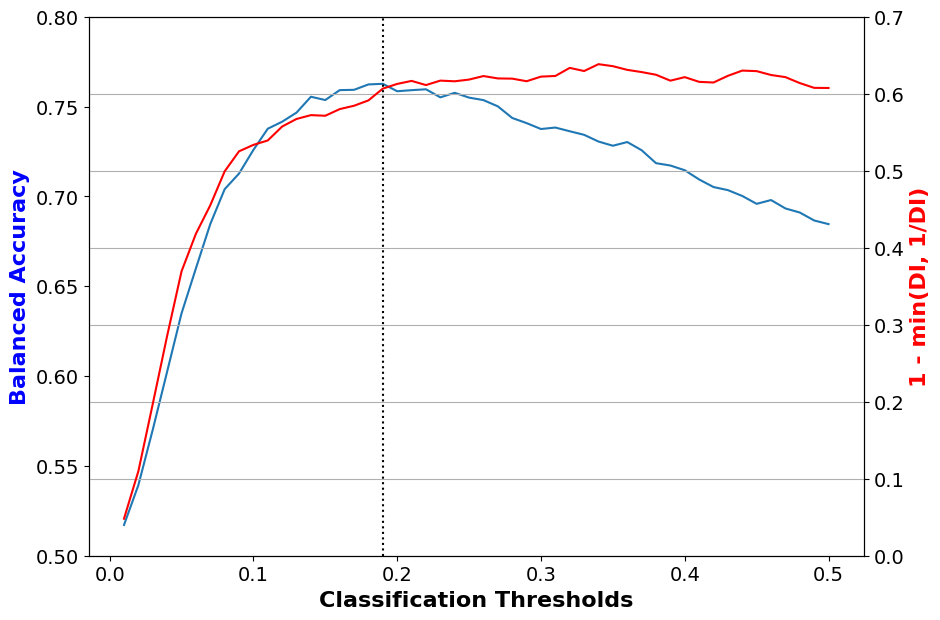

In [36]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

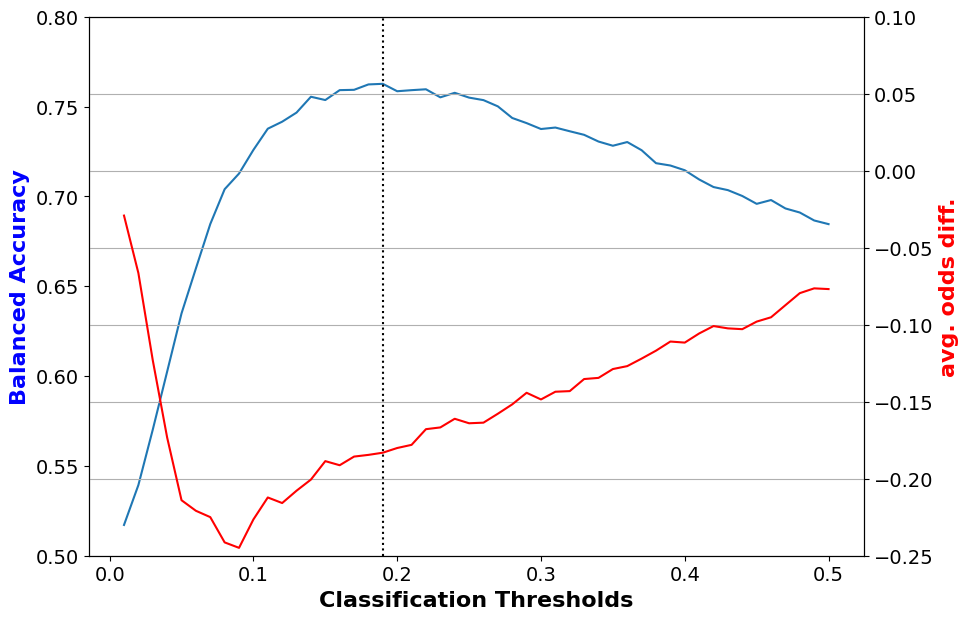

In [37]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

Make a function to print out accuracy and fairness metrics.

In [43]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [44]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7627
Corresponding 1-min(DI, 1/DI) value: 0.6066
Corresponding average odds difference value: -0.1831
Corresponding statistical parity difference value: -0.2643
Corresponding equal opportunity difference value: -0.1608
Corresponding Theil index value: 0.0936


### 3.2.3. Testing LR model on original data

In [45]:
lr_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=lr_orig_panel19,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [46]:
describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7759
Corresponding 1-min(DI, 1/DI) value: 0.5738
Corresponding average odds difference value: -0.2057
Corresponding statistical parity difference value: -0.2612
Corresponding equal opportunity difference value: -0.2228
Corresponding Theil index value: 0.0921


For all the fairness metrics displayed above, the value should be close to '0' for fairness.

1-min(DI, 1/DI) < 0.2 is typically desired for classifier predictions to be fair.

However, for a logistic regression classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

Similarly, average odds difference = ((FPR(unpriv) - FPR(priv)) + (TPR (unpriv - TPR(priv)))) / 2 must be close to zero for the classifier to be fair.

Again, the results for this classifier-data combination are still high. This still implies unfairness.



## 3.3. Learning a Random Forest (RF) classifier on original data

### 3.3.1. Training RF model on original data

In [47]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

### 3.3.2. Validating RF model on original data

In [48]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_orig_panel19,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

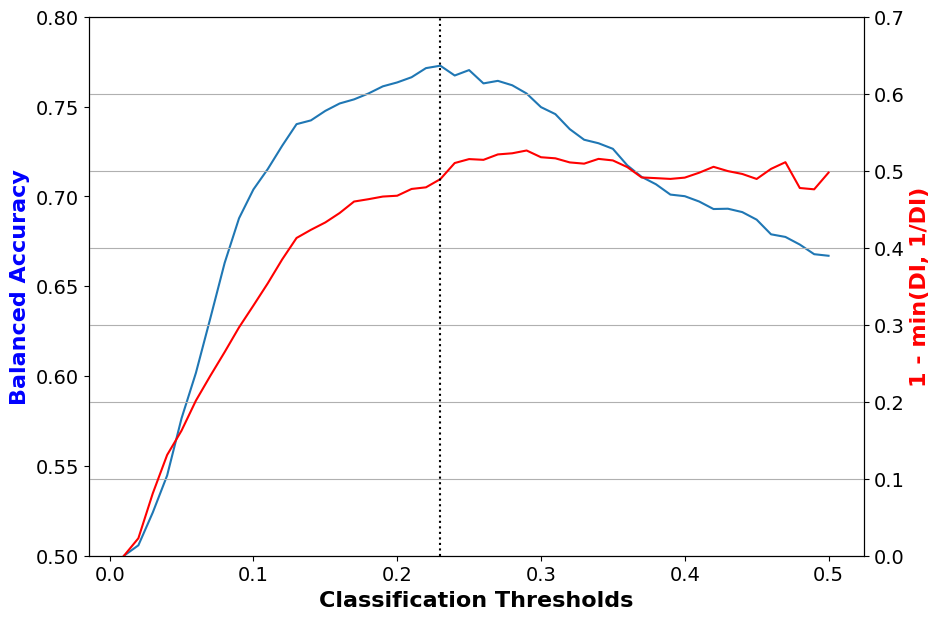

In [49]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

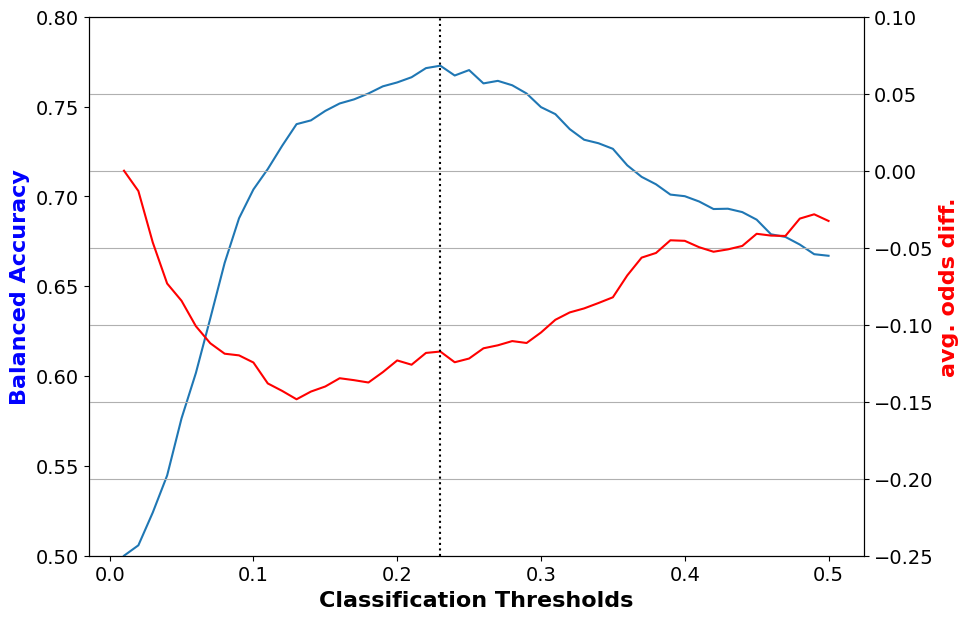

In [50]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [51]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7727
Corresponding 1-min(DI, 1/DI) value: 0.4891
Corresponding average odds difference value: -0.1174
Corresponding statistical parity difference value: -0.1952
Corresponding equal opportunity difference value: -0.1076
Corresponding Theil index value: 0.0893


### 3.3.3. Testing RF model on original data

In [52]:
rf_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=rf_orig_panel19,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

In [53]:
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7640
Corresponding 1-min(DI, 1/DI) value: 0.5040
Corresponding average odds difference value: -0.1346
Corresponding statistical parity difference value: -0.2121
Corresponding equal opportunity difference value: -0.1141
Corresponding Theil index value: 0.0944


### Section 3 Write Up here

### Part-01: For **both** the logistic regression and random forest classifiers learned on the original data, please include explain the results of your fairness metrics. For _each_ metric result briefly describe what this value means in 1-2 sentences (is it fair, is it not fair? Why?)

**Fairness Metric Summary** 
* Threshold corresponding to Best balanced accuracy:
* Best balanced accuracy: 
* Corresponding 1-min(DI, 1/DI) value: 
* Corresponding average odds difference value: 
* Corresponding statistical parity difference value: 
* Corresponding equal opportunity difference value:
* Corresponding Theil index value:

### Part-02: Please write one paragraph for each question.
1. How can we determine which metrics to use, given our data and use case? You can refer to [Course material](https://nanrahman.github.io/capstone-responsible-ai/weeks/06-Fairness-Assessments/), online research and Guidance provided by [AIF360](http://aif360.mybluemix.net/resources#)
2. When you have competing fairness metrics, how to pick which to prioritize?
3. What do you do when you encounter different definitions for similar metrics?
4. Based on this, which model and fairness metric appears the best to proceed with?

## Fairness Metrics Comparison Between Logistic Regression (LR) and Random Forest (RF)

### Threshold corresponding to Best balanced accuracy (LR vs RF) - 0.1900 vs 0.2300:
The threshold corresponding to best balanced accuracy represents the decision point where the model achieves its optimal balance between true positive and true negative rates. The threshold for LR is slightly lower, suggesting a different trade-off point for achieving balanced accuracy. Both thresholds aim to optimize fairness between true positive and true negative rates, though neither completely ensures fairness due to the subsequent disparities in other metrics.


### Best balanced accuracy (LR vs RF) - 0.7759 vs 0.7640:
Balanced accuracy averages accuracy across classes to handle imbalance and ensure each class is fairly represented. LR achieves slightly higher balanced accuracy than RF, indicating a better overall performance across both classes. However, this difference is marginal and may not signify a considerable advantage in fairness.


### 1-min(DI, 1/DI) value (LR vs RF) - 0.5738 vs 0.5040:
This metric measures the degree of disparate impact, with values closer to 0 indicating less disparity between groups. RF has a lower value, indicating slightly better fairness in terms of disparate impact, although both values reflect a significant disparity between groups. Neither model fully achieves fairness as values closer to 0 are preferred.


### Average odds difference (LR vs RF) - -0.2057 vs -0.1346:
Average odds difference compares the true positive and false positive rates across groups, with values near 0 indicating fairness. RF’s average odds difference is closer to 0, which suggests it has less disparity in the odds of correct positive predictions between groups, making it marginally fairer than LR in this aspect.


### Statistical parity difference (LR vs RF) - -0.2612 vs -0.2121:
Statistical parity difference measures the disparity in positive outcome rates between groups, with values close to 0 indicating fairness. RF’s statistical parity difference is closer to 0, indicating it has a smaller disparity in positive outcome rates between groups. This suggests RF is slightly more fair in providing equal opportunity for positive outcomes.


### Equal opportunity difference (LR vs RF) - -0.2228 vs -0.1141:
Equal opportunity difference reflects the difference in true positive rates between groups, with near-zero values indicating fairness. RF again shows a smaller disparity, suggesting it offers more equal true positive rates across groups compared to LR. However, both models still exhibit notable inequalities in opportunity.


### Theil index (LR vs RF) - 0.0921 vs 0.0944:
The Theil index measures distributional inequality, with lower values suggesting less unfairness in outcome distribution. Both models have similar Theil index values, indicating low but comparable levels of inequality in distributional fairness. The small difference here suggests minimal information loss due to unfair predictions for both models.

## Part-02: One Paragraph for Each Question

### How can we determine which metrics to use, given our data and use case?  

The choice of fairness metrics depends on the data, use case, and ethical implications of model decisions. For example, if equal opportunity matters, metrics like equal opportunity difference or average odds difference are key. Here, RF had better equal opportunity difference than LR, so RF could be a better choice for equal opportunity. Guidance from AIF360 and course materials recommends aligning fairness metrics with demographic impacts and stakeholder control over attributes.

### When you have competing fairness metrics, how to pick which to prioritize? 

To prioritize competing fairness metrics, consider the context and consequences of focusing on one fairness aspect over another. In our analysis, RF showed better disparate impact and statistical parity difference, indicating fairer outcomes across groups. In healthcare, equal opportunity might be prioritized to ensure fairness for all groups, while financial settings may prioritize disparate impact. 


### What do you do when you encounter different definitions for similar metrics? 

When facing different definitions for similar metrics, understanding the underlying concepts and assumptions of each is critical. For example, both average odds difference and equal opportunity difference address group disparities but in different ways (positive prediction rates versus true positive rates). Knowing these distinctions helps choose the metric that best suits the context.

### Based on this, which model and fairness metric appears the best to proceed with? 

Based on the metrics, the RF model is better due to its lower 1-min(DI, 1/DI), average odds difference, and statistical parity difference, suggesting fairer prediction distribution. RF also has a better equal opportunity difference, implying more equality in true positive rates. RF's improved fairness, especially in equal opportunity and disparate impact, makes it preferable when fairness is prioritized over minor balanced accuracy gains. In summary, focusing on reducing statistical parity difference and average odds difference in the RF model could yield the most equitable results.

### [4.](#Table-of-Contents) Additional Model Development


### 4.1A Load data & create splits for learning/validating/testing model

In [65]:
# Use the same methods from Section 3
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_panel19_train = RW.fit_transform(dataset_orig_panel19_train)

In [66]:
metric_transf_panel19_train = BinaryLabelDatasetMetric(
        dataset_transf_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_panel19_train = MetricTextExplainer(metric_transf_panel19_train)

print(explainer_transf_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0


### 4.2 Learning a Logistic Regression (LR) classifier on data transformed by reweighing

In [67]:
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [68]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_transf_panel19,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

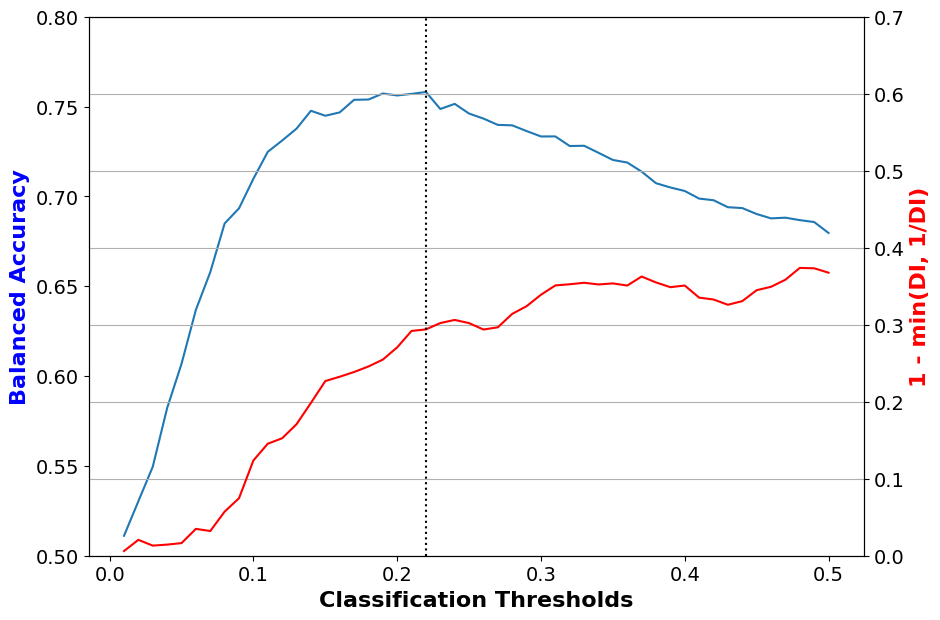

In [69]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

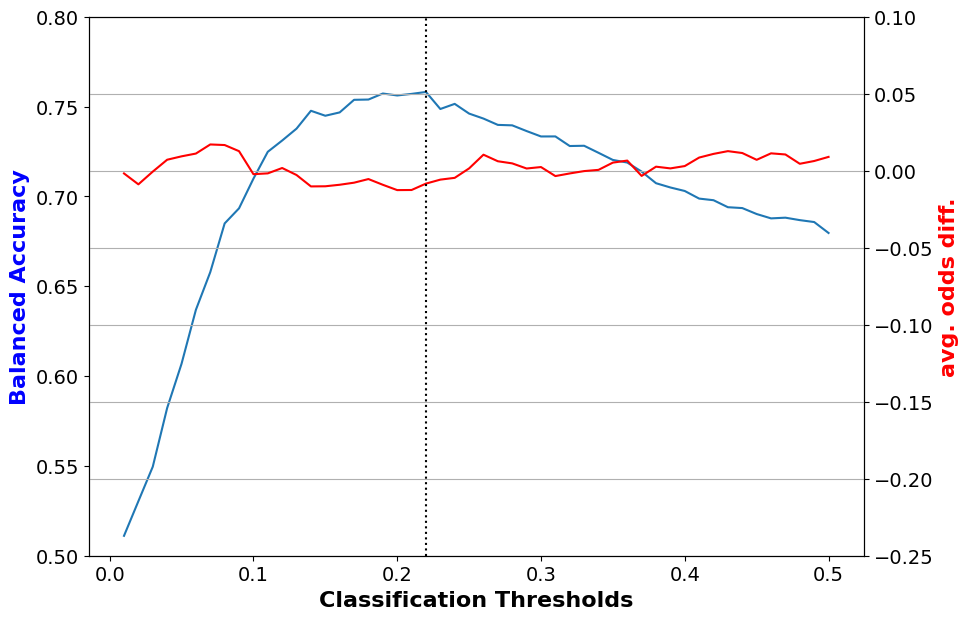

In [70]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [71]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7581
Corresponding 1-min(DI, 1/DI) value: 0.2939
Corresponding average odds difference value: -0.0084
Corresponding statistical parity difference value: -0.0992
Corresponding equal opportunity difference value: 0.0242
Corresponding Theil index value: 0.0938


### 4.2.3. Testing LR model after reweighing

In [72]:
lr_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=lr_transf_panel19,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])

In [73]:
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7539
Corresponding 1-min(DI, 1/DI) value: 0.2482
Corresponding average odds difference value: -0.0151
Corresponding statistical parity difference value: -0.0872
Corresponding equal opportunity difference value: -0.0035
Corresponding Theil index value: 0.0966


### 4.3. Learning a Random Forest (RF) classifier on original data

In [74]:
# Use the same methods from Section 3
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [75]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_transf_panel19,
                   thresh_arr=thresh_arr)
rf_transf_best_ind = np.argmax(val_metrics['bal_acc'])

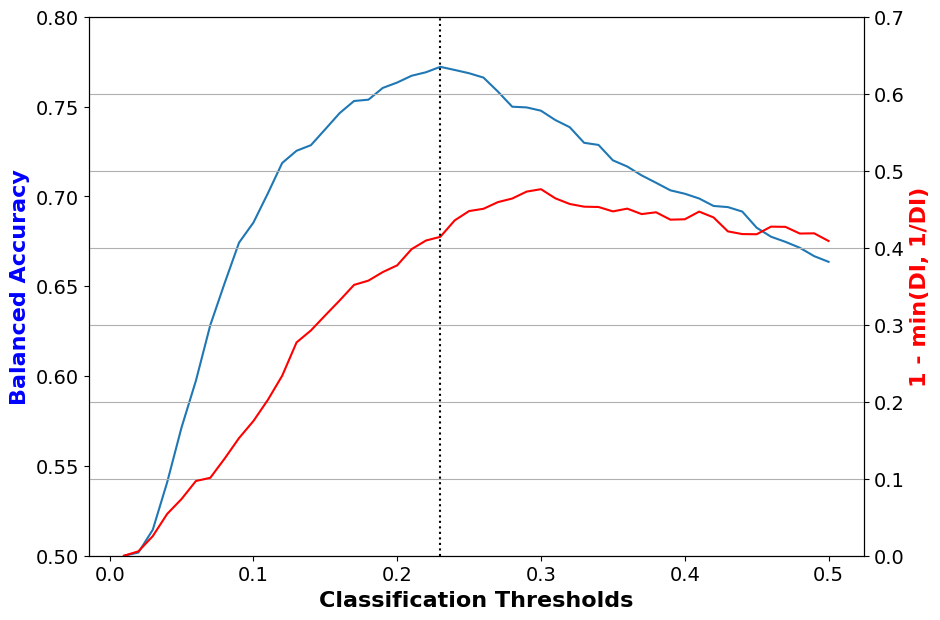

In [76]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

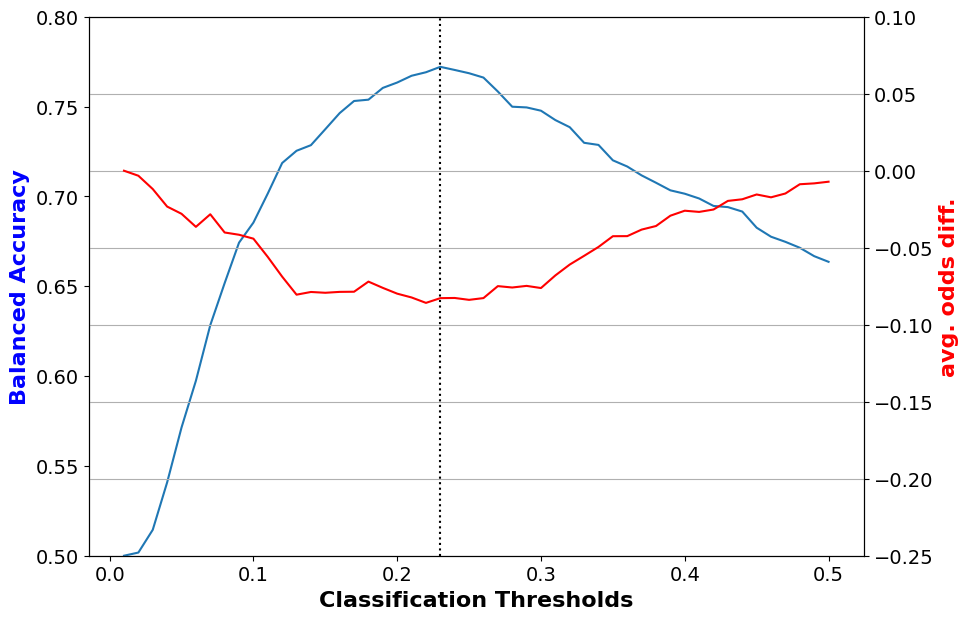

In [77]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [78]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7721
Corresponding 1-min(DI, 1/DI) value: 0.4142
Corresponding average odds difference value: -0.0827
Corresponding statistical parity difference value: -0.1623
Corresponding equal opportunity difference value: -0.0713
Corresponding Theil index value: 0.0882


### 4.3.3. Testing RF model after reweighing

In [79]:
rf_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=rf_transf_panel19,
                         thresh_arr=[thresh_arr[rf_transf_best_ind]])

In [80]:
describe_metrics(rf_transf_metrics, [thresh_arr[rf_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7644
Corresponding 1-min(DI, 1/DI) value: 0.4336
Corresponding average odds difference value: -0.1014
Corresponding statistical parity difference value: -0.1776
Corresponding equal opportunity difference value: -0.0842
Corresponding Theil index value: 0.0938


### Section 4 Write Up here

**1. For both the logistic regression and random forest classifiers learned on the original data, please include the results of your fairness metrics. For _each_ metric result briefly describe (1-2 sentences) if you saw any differences from your results in Part 3, and what that might mean.**

_Fairness Metrics_

##### Logistic regression: 
* Threshold corresponding to Best balanced accuracy: 0.2200 - increased from .19, indicating after we did the reweighing, the decision boundary changed to balance true negative and true positives.  


* Best balanced accuracy: 0.7581- decreased from .7759. This is roughly the same, so I wouldn’t say we can make any conclusions from this  


* Corresponding 1-min(DI, 1/DI) value: 0.2939 - decreased from .5739! This could imply a significant improvement in disparate impact, indicating that the model became more fair in how it predicts outcomes between groups.


* Corresponding average odds difference value: -0.0084 - improved from -0.2057, this metric shows a reduction in bias regarding the odds of receiving favorable outcomes, which points towards more equal treatment across groups (more fair). 


* Corresponding statistical parity difference value: -0.0992 -  Improved from -0.2612 to -0.0992, indicating that the likelihood of a positive outcome became more fair between different groups


* Corresponding equal opportunity difference value: 0.0242 - improved form -.2228, which is a significant improvement! This would imply that the rewighing helped equalize true positive rates 


* Corresponding Theil index value: 0.0938 - increased slightly from .0921, but this change is pretty small so it would be tough to draw any conclusions from here. 

##### Random Forest: 

* Threshold corresponding to Best balanced accuracy: 0.2300 -  remained the same, no conclusion to be drawn 

* Best balanced accuracy: 0.7644 - slight increase but  pretty insignificant, no conclusion can be drawn

* Corresponding 1-min(DI, 1/DI) value: 0.4336 - decreased from 0.5040, which represents an improvement in reducing disparate impact. This indicates that the model became somewhat more equitable in predicting outcomes across different groups

* Corresponding average odds difference value: -0.1014 - small improvement from -0.1346, showing a reduction in bias concerning the odds of receiving favorable outcomes, moving towards more equitable treatment across different groups.

* Corresponding statistical parity difference value: -0.1776 - Improved from -0.2121, suggesting that the likelihood of a positive outcome has become fairer and more balanced between different demographic groups after reweighing.

* Corresponding equal opportunity difference value: -0.0842 - slight improvement from -0.1141, indicating that reweighing helped to make the true positive rates more equal across different groups. 

* Corresponding Theil index value: 0.0938 slightly decreased from .0944 but difference semes insignificant to draw any conclusions 

    
**2. Based on this, would you make any recommendations during model development? Does it change which model and fairness metric would be the best to proceed with?** (Please write at least one paragraph)

After seeing the results from part 3 and 4, we would suggest to continue to focus efforts on the reweighing strategies. With these strategies, our models became a lot more fair for both the logistical regression and the random forest models. However, it seems like the logistical regression model after reweighing is more fair overall than the random forest. Its 1min and avg odds difference is significantly better, which is how we are drawing that conclusion. I would recommend exploring some feature engineering or other reweighing tactics to try and make this model even more fair. 



### End of Replication Part 02 -  Model Development and Fairness Evaluation

----


### [5.](#Table-of-Contents) Bias Mitigation

### [6.](#Table-of-Contents) Results Summary

### [7.](#Table-of-Contents) Explainability

### [8.](#Table-of-Contents) Conclusion & Discussion